# Liquidity of Pools Related with Bostrom and Space-Pussy

In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import chain

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom, Space-Pussy and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=False, bostrom_related_osmo_pools=None)
pools_df = \
    pools_df[
        (pools_df.network.isin(['bostrom', 'space-pussy'])) |
        (pools_df.reserve_coin_denoms.map(lambda denoms: 'boot in osmosis' in denoms))]
pools_df

,network,id,type_id,balances,reserve_coin_denoms,swap_fee
0,bostrom,1,1,"[{'denom': 'boot', 'amount': '8884565755836'},...","[boot, hydrogen]",0.0030
1,bostrom,2,1,"[{'denom': 'boot', 'amount': '11254051814'}, {...","[boot, milliampere]",0.0030
2,bostrom,3,1,"[{'denom': 'boot', 'amount': '33774478296'}, {...","[boot, tocyb]",0.0030
3,bostrom,4,1,"[{'denom': 'hydrogen', 'amount': '576742308802...","[hydrogen, tocyb]",0.0030
4,bostrom,5,1,"[{'denom': 'hydrogen', 'amount': '320416366022...","[hydrogen, milliampere]",0.0030
5,bostrom,6,1,"[{'denom': 'hydrogen', 'amount': '264110207164...","[hydrogen, millivolt]",0.0030
6,bostrom,7,1,"[{'denom': 'hydrogen', 'amount': '466309104471...","[hydrogen, uosmo in bostrom]",0.0030
7,bostrom,8,1,[],"[hydrogen, deprecated uatom in bostrom]",0.0030
8,bostrom,9,1,[],"[uosmo in bostrom, deprecated uatom in bostrom]",0.0030
9,bostrom,10,1,"[{'denom': 'milliampere', 'amount': '654594463...","[milliampere, millivolt]",0.0030


#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True, zero_fee=True)

,liquidpussy in bostrom,uosmo in bostrom,ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,boot,ugraviton in bostrom,uatom in bostrom,weth.grv in bostrom,uatom in osmosis,weth in osmosis,deprecated uatom in bostrom,ibc/E97634A40119F1898989C2A23224ED83FDD0A57EA46B3A094E287288D1672B44,weth.grv in osmosis,liquidpussy,millivolt(pussy),uosmo,boot in osmosis,pussy in bostrom,ujuno in bostrom,hydrogen,pussy,milliampere,millivolt,ujuno in osmosis,uion,udsm in bostrom,milliampere(pussy),aevmos in bostrom,tocyb,dot in osmosis,uatom,ujuno
liquidpussy in bostrom,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,23002.102656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,1,NaN,NaN,NaN,21.102627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.008282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71367222532.077789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot,NaN,NaN,NaN,1,NaN,1185.273,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000058,NaN,0.468196,NaN,1511.419439,14314.495322,NaN,NaN,NaN,NaN,NaN,1.408,NaN,NaN,NaN
ugraviton in bostrom,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.836368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uatom in bostrom,NaN,0.047387,NaN,0.000844,NaN,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.000392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
weth.grv in bostrom,NaN,NaN,NaN,3907415.751691,NaN,4384326725.793342,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1666366.838234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uatom in osmosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
weth in osmosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,3779557.274022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deprecated uatom in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,liquidpussy in bostrom,uosmo in bostrom,ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,boot,ugraviton in bostrom,uatom in bostrom,weth.grv in bostrom,uatom in osmosis,weth in osmosis,deprecated uatom in bostrom,ibc/E97634A40119F1898989C2A23224ED83FDD0A57EA46B3A094E287288D1672B44,weth.grv in osmosis,liquidpussy,millivolt(pussy),uosmo,boot in osmosis,pussy in bostrom,ujuno in bostrom,hydrogen,pussy,milliampere,millivolt,ujuno in osmosis,uion,udsm in bostrom,milliampere(pussy),aevmos in bostrom,tocyb,dot in osmosis,uatom,ujuno
liquidpussy in bostrom,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,50015.71958,NaN,NaN,2.973885,NaN,23002.102656,2.973885,NaN,NaN,NaN,NaN,NaN,7445.809816,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,1,NaN,0.018324,NaN,21.102627,NaN,21.102627,NaN,NaN,NaN,NaN,NaN,NaN,1,0.018324,NaN,NaN,0.008282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.102627,NaN
ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,NaN,NaN,1,71367222532.077789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71367222532.077789,NaN,NaN,33413843062.282295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot,NaN,54.57319,0.0,1,NaN,1185.273,0.0,1150.47878,0.0,NaN,0.799706,0.0,NaN,NaN,54.57319,1,0.000058,26.062982,0.468196,0.000058,1511.419439,14314.495322,26.062982,37557.0,NaN,NaN,NaN,1.408,0.066989,1150.47878,26.062982
ugraviton in bostrom,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.836368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uatom in bostrom,NaN,0.047387,NaN,0.000844,NaN,1,0.0,1,NaN,NaN,NaN,0.0,NaN,NaN,0.047387,0.000844,0.0,NaN,0.000392,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
weth.grv in bostrom,NaN,NaN,NaN,3907415.751691,NaN,4384326725.793342,1,4384326725.793342,NaN,NaN,NaN,1,NaN,NaN,NaN,3907415.751691,NaN,NaN,1666366.838234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4384326725.793342,NaN
uatom in osmosis,NaN,0.047387,NaN,0.000869,NaN,1,0.0,1,NaN,NaN,NaN,0.0,NaN,NaN,0.047387,0.000869,0.0,NaN,0.000392,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
weth in osmosis,NaN,NaN,NaN,3779557.274022,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,3779557.274022,NaN,NaN,1769573.329582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deprecated uatom in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GH"
space-pussy,1,"[liquidpussy, pussy]",254.6
space-pussy,3,"[liquidpussy, millivolt(pussy)]",60.0
space-pussy,2,"[liquidpussy, milliampere(pussy)]",35.0
space-pussy,4,"[milliampere(pussy), millivolt(pussy)]",12.2
space-pussy,5,"[milliampere(pussy), pussy]",1.9
osmosis,912,"[weth in osmosis, boot in osmosis]","1,565.6"
osmosis,596,"[uatom in osmosis, boot in osmosis]","1,473.5"
osmosis,911,"[weth.grv in osmosis, boot in osmosis]",622.2
osmosis,597,"[boot in osmosis, uosmo]",209.8
osmosis,919,"[dot in osmosis, boot in osmosis]",1.5


Total liquidity: 148,173 GH


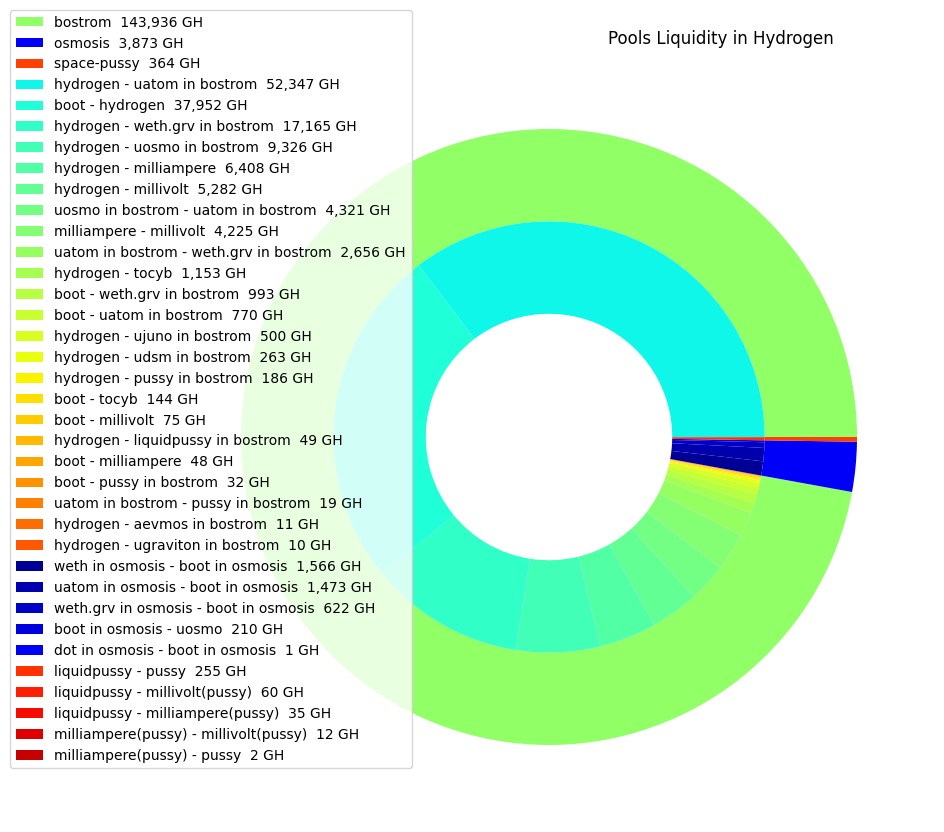

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'hydrogen', main_liquidity_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']: int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(
            price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return 0


pools_df['liquidity, GH'] = pools_df['balances'].map(get_pool_liquidity) / 1e9
display(HTML(
    pools_df[['network', 'id', 'reserve_coin_denoms', 'liquidity, GH']]
    .sort_values(['network', 'liquidity, GH'], ascending=False)
    .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
    .replace('text-align: left;', 'text-align: right')
    .replace('<tr>', '<tr align="right">')))

print(
    f"Total liquidity: {round(sum(pools_df['liquidity, GH'])):>,} GH")

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cm2 = plt.get_cmap("jet", 50)
cout = cm(np.array([10, 2, 16]))


pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df.groupby('network')['liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = pools_df[pools_df['liquidity, GH'] > 1].groupby(
    ['network', 'denoms'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm2(np.array(list(range(18, 41)) + list(range(1, 6)) + list(range(42, 49))))
ax.pie(inner.values.flatten(),
       radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Pools Liquidity in Hydrogen'+' '*19, loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.2, 0.07))
handles, labels = ax.get_legend_handles_labels()
plt.show()

pools_df.to_csv('data/pools_liquidity.csv')

### Liquidity by Coins

Liquidity by Coins


coin,network,"liquidity, GH"
hydrogen,bostrom,65326.468091
uatom in bostrom,bostrom,30056.623171
boot,bostrom,20007.223435
weth.grv in bostrom,bostrom,10407.084811
uosmo in bostrom,bostrom,6823.783102
milliampere,bostrom,5340.592032
millivolt,bostrom,4790.928319
boot in osmosis,osmosis,1936.408349
weth in osmosis,osmosis,782.803822
uatom in osmosis,osmosis,736.784147


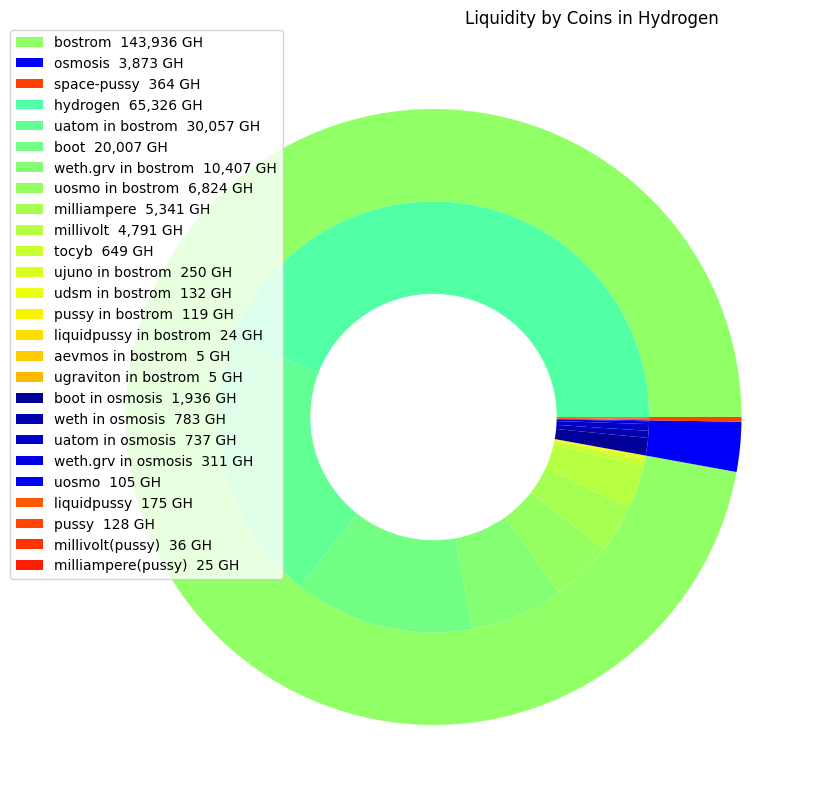

In [6]:
coin_list = set(chain(*pools_df.reserve_coin_denoms.to_list()))
coin_liquidity_data = []
coin_liquidity_df = pd.DataFrame(columns=['coin', 'network', 'liquidity, GH'])
for coin_denom in coin_list:
    pools_liquidity_agg_by_network_df = \
        pools_df[pools_df.reserve_coin_denoms.map(lambda x: coin_denom in x)].groupby('network')['liquidity, GH'].sum() * 0.5
    for network, coin_liquidity in pools_liquidity_agg_by_network_df.items():
        coin_liquidity_data.append({
            'coin': coin_denom,
            'network': network,
            'liquidity, GH': coin_liquidity})
coin_liquidity_df = pd.DataFrame(coin_liquidity_data).sort_values('liquidity, GH', ascending=False).reset_index().drop(columns=['index'])

print('Liquidity by Coins')
display(HTML(
    coin_liquidity_df.to_html(
                index=False, notebook=True, show_dimensions=False)))

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.array([10, 2, 16]))

outer = coin_liquidity_df.groupby('network')['liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = coin_liquidity_df[coin_liquidity_df['liquidity, GH'] > 1].groupby(
    ['network', 'coin'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[True],
                                                                                             inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cm2 = plt.get_cmap("jet", 50)
cin = cm2(np.array(list(range(22, 36)) + list(range(1, 6)) + list(range(40, 45))))
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Liquidity by Coins in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.05, 0.29))
handles, labels = ax.get_legend_handles_labels()
plt.show()

coin_liquidity_df.to_csv('data/coins_liquidity.csv')